# 🔧 Step 4: Feature Engineering

## Magnificent 7 Stock Prediction Project

### Objectives:
1. Create technical indicators (RSI, MACD, Bollinger Bands, etc.)
2. Generate lag features for time series
3. Calculate rolling statistics
4. Add market regime features
5. Create target variables for prediction

---

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta import add_all_ta_features
from ta.trend import MACD, EMAIndicator, SMAIndicator, ADXIndicator
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Magnificent 7 tickers
MAGNIFICENT_7 = {
    'AAPL': 'Apple',
    'MSFT': 'Microsoft', 
    'NVDA': 'NVIDIA',
    'TSLA': 'Tesla',
    'AMZN': 'Amazon',
    'META': 'Meta',
    'GOOGL': 'Google'
}
TICKERS = list(MAGNIFICENT_7.keys())

print('✅ Libraries loaded successfully')
print(f'📊 Processing {len(TICKERS)} stocks: {TICKERS}')

✅ Libraries loaded successfully
📊 Processing 7 stocks: ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'META', 'GOOGL']


In [3]:
# Load cleaned data
stock_data = {}
for ticker in TICKERS:
    file_path = f'../data/cleaned/{ticker}_cleaned.csv'
    df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    stock_data[ticker] = df
    print(f'✅ {ticker}: {len(df)} rows')

# Load close prices and returns
close_prices = pd.read_csv('../data/cleaned/mag7_close_prices.csv', index_col=0, parse_dates=True)
returns = pd.read_csv('../data/cleaned/mag7_returns.csv', index_col=0, parse_dates=True)

# Load market indices
df_indices = pd.read_csv('../data/raw/market_indices.csv', index_col='Date', parse_dates=True)

print(f'\n📊 Close prices: {close_prices.shape}')
print(f'📊 Returns: {returns.shape}')
print(f'📊 Market indices: {df_indices.shape}')

✅ AAPL: 2021 rows
✅ MSFT: 2021 rows
✅ NVDA: 2021 rows
✅ TSLA: 2021 rows
✅ AMZN: 2021 rows
✅ META: 2021 rows
✅ GOOGL: 2021 rows

📊 Close prices: (2021, 7)
📊 Returns: (2020, 7)
📊 Market indices: (2021, 3)


## 2. Technical Indicators

In [4]:
def add_technical_indicators(df):
    """
    Add comprehensive technical indicators to stock dataframe.
    """
    df = df.copy()
    
    # Ensure we have required columns
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['Volume']
    
    # ============ TREND INDICATORS ============
    
    # Simple Moving Averages
    df['SMA_5'] = SMAIndicator(close, window=5).sma_indicator()
    df['SMA_10'] = SMAIndicator(close, window=10).sma_indicator()
    df['SMA_20'] = SMAIndicator(close, window=20).sma_indicator()
    df['SMA_50'] = SMAIndicator(close, window=50).sma_indicator()
    df['SMA_200'] = SMAIndicator(close, window=200).sma_indicator()
    
    # Exponential Moving Averages
    df['EMA_12'] = EMAIndicator(close, window=12).ema_indicator()
    df['EMA_26'] = EMAIndicator(close, window=26).ema_indicator()
    df['EMA_50'] = EMAIndicator(close, window=50).ema_indicator()
    
    # MACD
    macd = MACD(close)
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Hist'] = macd.macd_diff()
    
    # ADX (Average Directional Index)
    adx = ADXIndicator(high, low, close)
    df['ADX'] = adx.adx()
    df['ADX_Pos'] = adx.adx_pos()
    df['ADX_Neg'] = adx.adx_neg()
    
    # ============ MOMENTUM INDICATORS ============
    
    # RSI
    df['RSI_14'] = RSIIndicator(close, window=14).rsi()
    df['RSI_7'] = RSIIndicator(close, window=7).rsi()
    
    # Stochastic Oscillator
    stoch = StochasticOscillator(high, low, close)
    df['Stoch_K'] = stoch.stoch()
    df['Stoch_D'] = stoch.stoch_signal()
    
    # Rate of Change
    df['ROC_5'] = close.pct_change(5) * 100
    df['ROC_10'] = close.pct_change(10) * 100
    df['ROC_20'] = close.pct_change(20) * 100
    
    # ============ VOLATILITY INDICATORS ============
    
    # Bollinger Bands
    bb = BollingerBands(close, window=20)
    df['BB_Upper'] = bb.bollinger_hband()
    df['BB_Middle'] = bb.bollinger_mavg()
    df['BB_Lower'] = bb.bollinger_lband()
    df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle']
    df['BB_Pct'] = (close - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    
    # Average True Range
    df['ATR'] = AverageTrueRange(high, low, close).average_true_range()
    df['ATR_Pct'] = df['ATR'] / close * 100  # ATR as % of price
    
    # Historical Volatility
    df['Volatility_10'] = close.pct_change().rolling(10).std() * np.sqrt(252) * 100
    df['Volatility_20'] = close.pct_change().rolling(20).std() * np.sqrt(252) * 100
    
    # ============ VOLUME INDICATORS ============
    
    # On-Balance Volume
    df['OBV'] = OnBalanceVolumeIndicator(close, volume).on_balance_volume()
    
    # Volume Moving Averages
    df['Volume_SMA_20'] = volume.rolling(20).mean()
    df['Volume_Ratio'] = volume / df['Volume_SMA_20']
    
    return df

print('✅ Technical indicator function defined')

✅ Technical indicator function defined


In [5]:
# Apply technical indicators to all stocks
stock_data_features = {}

for ticker in TICKERS:
    print(f'Processing {ticker}...')
    stock_data_features[ticker] = add_technical_indicators(stock_data[ticker])
    
print(f'\n✅ Technical indicators added to all stocks')
print(f'📊 Features per stock: {len(stock_data_features["AAPL"].columns)}')
print(f'\nNew columns: {[col for col in stock_data_features["AAPL"].columns if col not in stock_data["AAPL"].columns]}')

Processing AAPL...
Processing MSFT...
Processing NVDA...
Processing TSLA...
Processing AMZN...
Processing META...
Processing GOOGL...

✅ Technical indicators added to all stocks
📊 Features per stock: 41

New columns: ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_12', 'EMA_26', 'EMA_50', 'MACD', 'MACD_Signal', 'MACD_Hist', 'ADX', 'ADX_Pos', 'ADX_Neg', 'RSI_14', 'RSI_7', 'Stoch_K', 'Stoch_D', 'ROC_5', 'ROC_10', 'ROC_20', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_Width', 'BB_Pct', 'ATR', 'ATR_Pct', 'Volatility_10', 'Volatility_20', 'OBV', 'Volume_SMA_20', 'Volume_Ratio']


## 3. Lag Features

In [6]:
def add_lag_features(df, lags=[1, 2, 3, 5, 10, 20]):
    """
    Add lag features for time series prediction.
    """
    df = df.copy()
    
    # Daily returns
    df['Return'] = df['Close'].pct_change()
    
    # Lag features for returns
    for lag in lags:
        df[f'Return_Lag_{lag}'] = df['Return'].shift(lag)
    
    # Lag features for RSI
    for lag in [1, 5, 10]:
        df[f'RSI_Lag_{lag}'] = df['RSI_14'].shift(lag)
    
    # Lag features for volume ratio
    for lag in [1, 5]:
        df[f'Volume_Ratio_Lag_{lag}'] = df['Volume_Ratio'].shift(lag)
    
    # Lag features for volatility
    for lag in [1, 5]:
        df[f'Volatility_Lag_{lag}'] = df['Volatility_20'].shift(lag)
    
    return df

# Apply lag features
for ticker in TICKERS:
    stock_data_features[ticker] = add_lag_features(stock_data_features[ticker])

print('✅ Lag features added')
lag_cols = [col for col in stock_data_features['AAPL'].columns if 'Lag' in col]
print(f'📊 Lag columns: {lag_cols}')

✅ Lag features added
📊 Lag columns: ['Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_5', 'Return_Lag_10', 'Return_Lag_20', 'RSI_Lag_1', 'RSI_Lag_5', 'RSI_Lag_10', 'Volume_Ratio_Lag_1', 'Volume_Ratio_Lag_5', 'Volatility_Lag_1', 'Volatility_Lag_5']


## 4. Rolling Statistics

In [7]:
def add_rolling_features(df):
    """
    Add rolling window statistics.
    """
    df = df.copy()
    
    returns = df['Return']
    
    # Rolling mean of returns
    df['Return_Mean_5'] = returns.rolling(5).mean()
    df['Return_Mean_10'] = returns.rolling(10).mean()
    df['Return_Mean_20'] = returns.rolling(20).mean()
    
    # Rolling std of returns
    df['Return_Std_5'] = returns.rolling(5).std()
    df['Return_Std_10'] = returns.rolling(10).std()
    df['Return_Std_20'] = returns.rolling(20).std()
    
    # Rolling skewness
    df['Return_Skew_20'] = returns.rolling(20).skew()
    
    # Rolling kurtosis
    df['Return_Kurt_20'] = returns.rolling(20).kurt()
    
    # Rolling min/max
    df['Close_Min_20'] = df['Close'].rolling(20).min()
    df['Close_Max_20'] = df['Close'].rolling(20).max()
    df['Close_Range_20'] = (df['Close_Max_20'] - df['Close_Min_20']) / df['Close']
    
    # Distance from 52-week high/low
    df['Close_Min_252'] = df['Close'].rolling(252, min_periods=50).min()
    df['Close_Max_252'] = df['Close'].rolling(252, min_periods=50).max()
    df['Dist_52W_High'] = (df['Close'] - df['Close_Max_252']) / df['Close_Max_252']
    df['Dist_52W_Low'] = (df['Close'] - df['Close_Min_252']) / df['Close_Min_252']
    
    # Cumulative return
    df['Cum_Return_5'] = (1 + returns).rolling(5).apply(lambda x: x.prod()) - 1
    df['Cum_Return_20'] = (1 + returns).rolling(20).apply(lambda x: x.prod()) - 1
    
    return df

# Apply rolling features
for ticker in TICKERS:
    stock_data_features[ticker] = add_rolling_features(stock_data_features[ticker])

print('✅ Rolling features added')
print(f'📊 Total features: {len(stock_data_features["AAPL"].columns)}')

✅ Rolling features added
📊 Total features: 72


## 5. Price Pattern Features

In [8]:
def add_price_patterns(df):
    """
    Add price pattern and signal features.
    """
    df = df.copy()
    
    # Price relative to moving averages
    df['Price_vs_SMA_20'] = (df['Close'] - df['SMA_20']) / df['SMA_20']
    df['Price_vs_SMA_50'] = (df['Close'] - df['SMA_50']) / df['SMA_50']
    df['Price_vs_SMA_200'] = (df['Close'] - df['SMA_200']) / df['SMA_200']
    
    # Moving average crossovers (signals)
    df['SMA_5_10_Cross'] = (df['SMA_5'] > df['SMA_10']).astype(int)
    df['SMA_20_50_Cross'] = (df['SMA_20'] > df['SMA_50']).astype(int)
    df['Golden_Cross'] = (df['SMA_50'] > df['SMA_200']).astype(int)
    
    # MACD signal
    df['MACD_Cross'] = (df['MACD'] > df['MACD_Signal']).astype(int)
    
    # RSI signals
    df['RSI_Oversold'] = (df['RSI_14'] < 30).astype(int)
    df['RSI_Overbought'] = (df['RSI_14'] > 70).astype(int)
    
    # Bollinger Band signals
    df['BB_Above_Upper'] = (df['Close'] > df['BB_Upper']).astype(int)
    df['BB_Below_Lower'] = (df['Close'] < df['BB_Lower']).astype(int)
    
    # Trend strength
    df['Strong_Uptrend'] = ((df['ADX'] > 25) & (df['ADX_Pos'] > df['ADX_Neg'])).astype(int)
    df['Strong_Downtrend'] = ((df['ADX'] > 25) & (df['ADX_Neg'] > df['ADX_Pos'])).astype(int)
    
    # Candle patterns (simple)
    df['Body_Size'] = abs(df['Close'] - df['Open']) / df['Open']
    df['Upper_Shadow'] = (df['High'] - df[['Close', 'Open']].max(axis=1)) / df['Open']
    df['Lower_Shadow'] = (df[['Close', 'Open']].min(axis=1) - df['Low']) / df['Open']
    df['Is_Bullish'] = (df['Close'] > df['Open']).astype(int)
    
    return df

# Apply price patterns
for ticker in TICKERS:
    stock_data_features[ticker] = add_price_patterns(stock_data_features[ticker])

print('✅ Price pattern features added')
print(f'📊 Total features: {len(stock_data_features["AAPL"].columns)}')

✅ Price pattern features added
📊 Total features: 89


## 6. Market Context Features

In [9]:
# Calculate market features from indices
market_features = pd.DataFrame(index=df_indices.index)

# S&P 500 features
market_features['SP500_Return'] = df_indices['GSPC'].pct_change()
market_features['SP500_Return_5D'] = df_indices['GSPC'].pct_change(5)
market_features['SP500_SMA_20'] = df_indices['GSPC'].rolling(20).mean()
market_features['SP500_vs_SMA'] = (df_indices['GSPC'] - market_features['SP500_SMA_20']) / market_features['SP500_SMA_20']

# VIX features
market_features['VIX'] = df_indices['VIX']
market_features['VIX_SMA_20'] = df_indices['VIX'].rolling(20).mean()
market_features['VIX_High'] = (df_indices['VIX'] > 25).astype(int)
market_features['VIX_Extreme'] = (df_indices['VIX'] > 35).astype(int)

# Market regime
market_features['Market_Bullish'] = (market_features['SP500_Return_5D'] > 0.02).astype(int)
market_features['Market_Bearish'] = (market_features['SP500_Return_5D'] < -0.02).astype(int)

print('✅ Market context features created')
print(f'📊 Market features: {list(market_features.columns)}')
display(market_features.tail())

✅ Market context features created
📊 Market features: ['SP500_Return', 'SP500_Return_5D', 'SP500_SMA_20', 'SP500_vs_SMA', 'VIX', 'VIX_SMA_20', 'VIX_High', 'VIX_Extreme', 'Market_Bullish', 'Market_Bearish']


,SP500_Return,SP500_Return_5D,SP500_SMA_20,SP500_vs_SMA,VIX,VIX_SMA_20,VIX_High,VIX_Extreme,Market_Bullish,Market_Bearish
Date,,,,,,,,,,
2026-01-09,0.006475,0.015719,6874.381494,0.013368,14.49,15.0540,0,0,0,0
2026-01-12,0.001578,0.010898,6878.194995,0.014404,15.12,15.0675,0,0,0,0
2026-01-13,-0.001939,0.002724,6885.011499,0.011435,15.98,15.0795,0,0,0,0
2026-01-14,-0.005333,0.000819,6890.516016,0.005237,16.75,15.0920,0,0,0,0
2026-01-15,0.002580,0.003324,6897.726538,0.006777,15.84,15.0600,0,0,0,0


In [10]:
# Add market features to each stock
for ticker in TICKERS:
    df = stock_data_features[ticker]
    # Merge on index (date)
    for col in market_features.columns:
        df[col] = market_features[col].reindex(df.index)
    stock_data_features[ticker] = df

print('✅ Market features added to all stocks')
print(f'📊 Total features per stock: {len(stock_data_features["AAPL"].columns)}')

✅ Market features added to all stocks
📊 Total features per stock: 99


## 7. Time-Based Features

In [11]:
def add_time_features(df):
    """
    Add calendar-based features.
    """
    df = df.copy()
    
    # Day of week (Monday=0, Friday=4)
    df['DayOfWeek'] = df.index.dayofweek
    df['Is_Monday'] = (df['DayOfWeek'] == 0).astype(int)
    df['Is_Friday'] = (df['DayOfWeek'] == 4).astype(int)
    
    # Month
    df['Month'] = df.index.month
    df['Is_January'] = (df['Month'] == 1).astype(int)  # January effect
    df['Is_December'] = (df['Month'] == 12).astype(int)  # Santa rally
    
    # Quarter
    df['Quarter'] = df.index.quarter
    df['Is_Q4'] = (df['Quarter'] == 4).astype(int)
    
    # Day of month
    df['DayOfMonth'] = df.index.day
    df['Is_MonthEnd'] = (df['DayOfMonth'] >= 25).astype(int)
    df['Is_MonthStart'] = (df['DayOfMonth'] <= 5).astype(int)
    
    return df

# Apply time features
for ticker in TICKERS:
    stock_data_features[ticker] = add_time_features(stock_data_features[ticker])

print('✅ Time-based features added')
print(f'📊 Total features per stock: {len(stock_data_features["AAPL"].columns)}')

✅ Time-based features added
📊 Total features per stock: 110


## 8. Target Variables

In [12]:
def add_target_variables(df):
    """
    Add target variables for prediction.
    """
    df = df.copy()
    
    # Future returns (targets for regression)
    df['Target_Return_1D'] = df['Close'].pct_change(1).shift(-1)  # Next day return
    df['Target_Return_5D'] = df['Close'].pct_change(5).shift(-5)  # 5-day forward return
    df['Target_Return_20D'] = df['Close'].pct_change(20).shift(-20)  # 20-day forward return
    
    # Direction (targets for classification)
    df['Target_Direction_1D'] = (df['Target_Return_1D'] > 0).astype(int)  # 1 = up, 0 = down
    df['Target_Direction_5D'] = (df['Target_Return_5D'] > 0).astype(int)
    
    # Significant move (up > 2%, down < -2%)
    df['Target_Big_Move_Up'] = (df['Target_Return_1D'] > 0.02).astype(int)
    df['Target_Big_Move_Down'] = (df['Target_Return_1D'] < -0.02).astype(int)
    
    return df

# Apply target variables
for ticker in TICKERS:
    stock_data_features[ticker] = add_target_variables(stock_data_features[ticker])

print('✅ Target variables added')
target_cols = [col for col in stock_data_features['AAPL'].columns if 'Target' in col]
print(f'📊 Target columns: {target_cols}')

✅ Target variables added
📊 Target columns: ['Target_Return_1D', 'Target_Return_5D', 'Target_Return_20D', 'Target_Direction_1D', 'Target_Direction_5D', 'Target_Big_Move_Up', 'Target_Big_Move_Down']


## 9. Feature Summary and Visualization

In [13]:
# Feature summary
print('='*70)
print('📊 FEATURE ENGINEERING SUMMARY')
print('='*70)

sample_df = stock_data_features['AAPL']
all_columns = list(sample_df.columns)

# Categorize features
original_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'dividends', 'stock_splits', 'Ticker']
trend_cols = [c for c in all_columns if any(x in c for x in ['SMA', 'EMA', 'MACD', 'ADX'])]
momentum_cols = [c for c in all_columns if any(x in c for x in ['RSI', 'Stoch', 'ROC'])]
volatility_cols = [c for c in all_columns if any(x in c for x in ['BB_', 'ATR', 'Volatility'])]
volume_cols = [c for c in all_columns if any(x in c for x in ['OBV', 'Volume_SMA', 'Volume_Ratio'])]
lag_cols = [c for c in all_columns if 'Lag' in c]
rolling_cols = [c for c in all_columns if any(x in c for x in ['Mean_', 'Std_', 'Skew', 'Kurt', 'Cum_', 'Min_', 'Max_', 'Range', 'Dist_'])]
pattern_cols = [c for c in all_columns if any(x in c for x in ['Cross', 'Oversold', 'Overbought', 'Above', 'Below', 'Trend', 'Body', 'Shadow', 'Bullish', 'Price_vs'])]
market_cols = [c for c in all_columns if any(x in c for x in ['SP500', 'VIX', 'Market'])]
time_cols = [c for c in all_columns if any(x in c for x in ['Day', 'Month', 'Quarter', 'Is_'])]
target_cols = [c for c in all_columns if 'Target' in c]

print(f"""
📋 FEATURE CATEGORIES:

1️⃣ Original Data:     {len([c for c in original_cols if c in all_columns])} features
2️⃣ Trend Indicators:  {len(trend_cols)} features
3️⃣ Momentum:          {len(momentum_cols)} features
4️⃣ Volatility:        {len(volatility_cols)} features
5️⃣ Volume:            {len(volume_cols)} features
6️⃣ Lag Features:      {len(lag_cols)} features
7️⃣ Rolling Stats:     {len(rolling_cols)} features
8️⃣ Price Patterns:    {len(pattern_cols)} features
9️⃣ Market Context:    {len(market_cols)} features
🔟 Time Features:     {len(time_cols)} features
🎯 Target Variables:  {len(target_cols)} features

📊 TOTAL FEATURES:    {len(all_columns)}
""")

📊 FEATURE ENGINEERING SUMMARY

📋 FEATURE CATEGORIES:

1️⃣ Original Data:     8 features
2️⃣ Trend Indicators:  24 features
3️⃣ Momentum:          12 features
4️⃣ Volatility:        13 features
5️⃣ Volume:            5 features
6️⃣ Lag Features:      13 features
7️⃣ Rolling Stats:     17 features
8️⃣ Price Patterns:    16 features
9️⃣ Market Context:    10 features
🔟 Time Features:     12 features
🎯 Target Variables:  7 features

📊 TOTAL FEATURES:    117



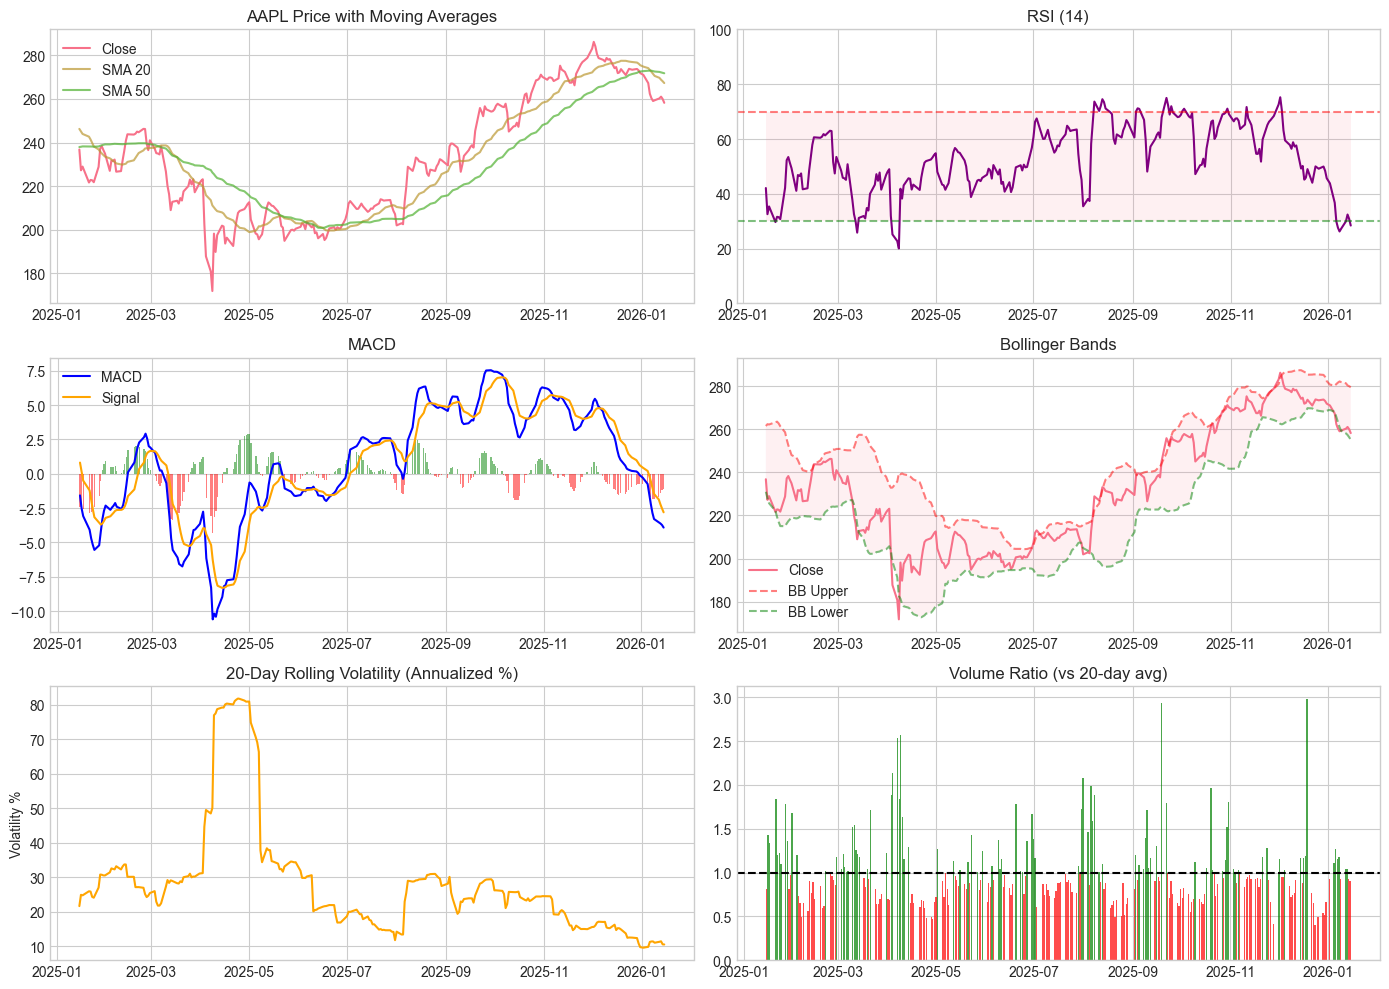

📊 Saved: data/features/feature_visualization.png


In [14]:
# Visualize sample of features for AAPL
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

sample = stock_data_features['AAPL'].tail(252)  # Last year

# Price with SMAs
ax = axes[0, 0]
ax.plot(sample.index, sample['Close'], label='Close', linewidth=1.5)
ax.plot(sample.index, sample['SMA_20'], label='SMA 20', alpha=0.7)
ax.plot(sample.index, sample['SMA_50'], label='SMA 50', alpha=0.7)
ax.set_title('AAPL Price with Moving Averages')
ax.legend()

# RSI
ax = axes[0, 1]
ax.plot(sample.index, sample['RSI_14'], color='purple')
ax.axhline(70, color='red', linestyle='--', alpha=0.5)
ax.axhline(30, color='green', linestyle='--', alpha=0.5)
ax.fill_between(sample.index, 30, 70, alpha=0.1)
ax.set_title('RSI (14)')
ax.set_ylim(0, 100)

# MACD
ax = axes[1, 0]
ax.plot(sample.index, sample['MACD'], label='MACD', color='blue')
ax.plot(sample.index, sample['MACD_Signal'], label='Signal', color='orange')
colors = ['green' if x > 0 else 'red' for x in sample['MACD_Hist']]
ax.bar(sample.index, sample['MACD_Hist'], color=colors, alpha=0.5)
ax.set_title('MACD')
ax.legend()

# Bollinger Bands
ax = axes[1, 1]
ax.plot(sample.index, sample['Close'], label='Close', linewidth=1.5)
ax.plot(sample.index, sample['BB_Upper'], 'r--', alpha=0.5, label='BB Upper')
ax.plot(sample.index, sample['BB_Lower'], 'g--', alpha=0.5, label='BB Lower')
ax.fill_between(sample.index, sample['BB_Lower'], sample['BB_Upper'], alpha=0.1)
ax.set_title('Bollinger Bands')
ax.legend()

# Volatility
ax = axes[2, 0]
ax.plot(sample.index, sample['Volatility_20'], color='orange')
ax.set_title('20-Day Rolling Volatility (Annualized %)')
ax.set_ylabel('Volatility %')

# Volume Ratio
ax = axes[2, 1]
colors = ['green' if x > 1 else 'red' for x in sample['Volume_Ratio']]
ax.bar(sample.index, sample['Volume_Ratio'], color=colors, alpha=0.7)
ax.axhline(1, color='black', linestyle='--')
ax.set_title('Volume Ratio (vs 20-day avg)')

plt.tight_layout()
plt.savefig('../data/features/feature_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: data/features/feature_visualization.png')

## 10. Handle Missing Values and Save

In [15]:
import os
os.makedirs('../data/features', exist_ok=True)

# Check missing values
print('🔍 Missing Values Analysis:')
print('-'*50)
for ticker in TICKERS:
    df = stock_data_features[ticker]
    missing = df.isnull().sum().sum()
    missing_pct = missing / df.size * 100
    print(f'{ticker}: {missing} missing ({missing_pct:.2f}%)')

# Most missing values are at the beginning (due to rolling windows)
# Let's see which rows have the most missing values
sample = stock_data_features['AAPL']
missing_by_row = sample.isnull().sum(axis=1)
print(f'\n📊 First row with <5 missing values: {sample.index[missing_by_row < 5][0]}')

🔍 Missing Values Analysis:
--------------------------------------------------
AAPL: 1638 missing (0.69%)
MSFT: 1638 missing (0.69%)
NVDA: 1638 missing (0.69%)
TSLA: 1638 missing (0.69%)
AMZN: 1638 missing (0.69%)
META: 1638 missing (0.69%)
GOOGL: 1638 missing (0.69%)

📊 First row with <5 missing values: 2018-03-14 00:00:00


In [16]:
# Drop rows with too many missing values (typically first ~200 rows due to SMA_200)
# Keep only rows where most features are available

stock_data_final = {}

for ticker in TICKERS:
    df = stock_data_features[ticker].copy()
    
    # Drop rows where SMA_200 is missing (first 200 trading days)
    df = df.dropna(subset=['SMA_200'])
    
    # Drop rows with target missing (last rows due to forward-looking)
    df = df.dropna(subset=['Target_Return_1D'])
    
    stock_data_final[ticker] = df
    print(f'{ticker}: {len(df)} rows after cleaning')

print(f'\n✅ All stocks cleaned')

AAPL: 1821 rows after cleaning
MSFT: 1821 rows after cleaning
NVDA: 1821 rows after cleaning
TSLA: 1821 rows after cleaning
AMZN: 1821 rows after cleaning
META: 1821 rows after cleaning
GOOGL: 1821 rows after cleaning

✅ All stocks cleaned


In [17]:
# Save feature-engineered data
for ticker in TICKERS:
    output_path = f'../data/features/{ticker}_features.csv'
    stock_data_final[ticker].to_csv(output_path)
    print(f'💾 Saved: data/features/{ticker}_features.csv')

# Save feature list
feature_list = list(stock_data_final['AAPL'].columns)
import json

feature_info = {
    'total_features': len(feature_list),
    'feature_names': feature_list,
    'target_columns': target_cols,
    'date_range': {
        'start': stock_data_final['AAPL'].index.min().strftime('%Y-%m-%d'),
        'end': stock_data_final['AAPL'].index.max().strftime('%Y-%m-%d')
    },
    'rows_per_stock': {ticker: len(stock_data_final[ticker]) for ticker in TICKERS}
}

with open('../data/features/feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f'\n💾 Saved: data/features/feature_info.json')

💾 Saved: data/features/AAPL_features.csv
💾 Saved: data/features/MSFT_features.csv
💾 Saved: data/features/NVDA_features.csv
💾 Saved: data/features/TSLA_features.csv
💾 Saved: data/features/AMZN_features.csv
💾 Saved: data/features/META_features.csv
💾 Saved: data/features/GOOGL_features.csv

💾 Saved: data/features/feature_info.json


In [18]:
# Create combined dataset for modeling
combined_features = pd.concat(
    [stock_data_final[ticker] for ticker in TICKERS],
    axis=0
)
combined_features = combined_features.reset_index()
combined_features.rename(columns={'index': 'Date'}, inplace=True)

combined_features.to_csv('../data/features/mag7_all_features.csv', index=False)
print(f'💾 Saved: data/features/mag7_all_features.csv')
print(f'   Shape: {combined_features.shape}')

💾 Saved: data/features/mag7_all_features.csv
   Shape: (12747, 118)


## 11. Final Summary

In [19]:
print('='*70)
print('🔧 FEATURE ENGINEERING COMPLETE')
print('='*70)

print(f"""
📊 SUMMARY:

✅ Total Features Created: {len(feature_list)}
✅ Stocks Processed: {len(TICKERS)}
✅ Date Range: {stock_data_final['AAPL'].index.min().strftime('%Y-%m-%d')} to {stock_data_final['AAPL'].index.max().strftime('%Y-%m-%d')}
✅ Rows per Stock: ~{len(stock_data_final['AAPL'])}

📁 FILES SAVED:
   • data/features/{{ticker}}_features.csv (x7)
   • data/features/mag7_all_features.csv
   • data/features/feature_info.json
   • data/features/feature_visualization.png

🎯 TARGET VARIABLES:
   • Target_Return_1D (next day return)
   • Target_Return_5D (5-day forward return)
   • Target_Return_20D (20-day forward return)
   • Target_Direction_1D (up/down classification)
   • Target_Direction_5D (5-day direction)
   • Target_Big_Move_Up (>2% move)
   • Target_Big_Move_Down (<-2% move)

{'='*70}
✅ Ready for 05_modeling.ipynb
{'='*70}
""")

🔧 FEATURE ENGINEERING COMPLETE

📊 SUMMARY:

✅ Total Features Created: 117
✅ Stocks Processed: 7
✅ Date Range: 2018-10-16 to 2026-01-14
✅ Rows per Stock: ~1821

📁 FILES SAVED:
   • data/features/{ticker}_features.csv (x7)
   • data/features/mag7_all_features.csv
   • data/features/feature_info.json
   • data/features/feature_visualization.png

🎯 TARGET VARIABLES:
   • Target_Return_1D (next day return)
   • Target_Return_5D (5-day forward return)
   • Target_Return_20D (20-day forward return)
   • Target_Direction_1D (up/down classification)
   • Target_Direction_5D (5-day direction)
   • Target_Big_Move_Up (>2% move)
   • Target_Big_Move_Down (<-2% move)

✅ Ready for 05_modeling.ipynb

